In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
plot_dir = './images/3D_images/'

# Constants

In [2]:
alpha = 1/137
r_o = 2.81794e-15 #m
m_p = 938.272 #MeV/c^2
m_e = .511 #MeV/c^2
m_pi = 134.9766 #MeV/c^2
q = 1.6e-19
h = 4.136e-21 #MeV*s 
h_bar = 6.582119569e-22 #Mev*s
c  = 3e8
N_A = 6.022e23


rho = 916.7 #kg/m^3 at 0C and atmospheric pressure
Z_nuc = 7.42 #Z_eff for water
A_r = Z_nuc/.55509 #Z/A = .55509
n = 1.309 #index of refraction of ice
X_o = 1/(4*alpha*(r_o**2)*rho*(N_A/A_r)*Z_nuc*(1+Z_nuc)*
         np.log(183/(Z_nuc**(1/3))))
X_1 = (1433/(.916)*A_r/
       (Z_nuc*(Z_nuc+1)*(11.319-np.log(Z_nuc))) / 100.)
X_o = X_1

abs_coeff   = 0.00853987      # according to Dima's data
abs_length  = 1 / abs_coeff
scat_coeff  = 0.0269972      # according to Dima's data
scat_length = 1 / scat_coeff

# detection_radius = .3 #half of the hole width
detection_radius = 10 # DOM oversizing
DOM_QE = .25

# Load Classes

In [3]:
class Particle: 
    def __init__(self, particle_type, mass, charge, 
                 direction, location, energy, time):
        self.particle_type = particle_type
        self.mass = mass
        self.charge = charge
        self.location = location # array of [x, y, z] 
        # to describe location
        self.direction = direction # array of [theta, phi] 
        # in direction of travel
        self.theta = self.direction[0]
        self.phi = self.direction[1]
        self.energy = energy
        self.beta = np.sqrt(1-(self.mass/self.energy)**2)
        self.momentum = np.sqrt(self.energy**2-self.mass**2)/c 
        self.time = time
        
    def update_energy(self, new_energy):
        self.energy = new_energy
        self.beta = np.sqrt(1-(self.mass/self.energy)**2)
        self.momentum = np.sqrt(self.energy**2-self.mass**2)/c 
        
    def save_particle(self, file_name):
        np.save(file_name, vars(self))

In [4]:
class DOM:
    def __init__(self, location):
        self.location = location
        self.triggered = False
        self.signals = []
        self.times = []
        
    def distance_from(self, location): 
        x = location[0]
        y = location[1]
        z = location[2]
        dom_x = self.location[0]
        dom_y = self.location[1]
        dom_z = self.location[2]
        return np.sqrt((dom_x - x)**2 + (dom_y - y)**2 
                        + (dom_z - z)**2)
    
    def trigger(self, time, num_photons=1): 
        self.triggered = True
        self.signals.append(num_photons)
        self.times.append(time)
        
    def clear_trigger(self):
        self.triggered = False
        self.signals = []
        self.times = []

In [5]:
class detector:
    def __init__(self, dom_list, file_name=None):
        if file_name is not None:
            saved_data = np.load(file_name, 
                                 allow_pickle = True)[()]
            dom_list = []
            for load_dom in saved_data:
                dom_list.append( DOM( load_dom['location'] ) )
                dom_list[-1].triggered = load_dom['trigger']
                dom_list[-1].signals   = load_dom['signals']
                dom_list[-1].times     = load_dom['times']  
                
        self.dom_list = dom_list
        
    def num_triggered(self): 
        num_triggered = 0
        for dom in self.dom_list: #CHANGED
            if dom.triggered: 
                num_triggered += 1
        return num_triggered
    
    def volume(self):
        points = [dom.location for dom in self.dom_list]
        region = ConvexHull(points)
        return region.volume
    
    def save_detector(self, file_name):
        output_array = []
        for DOM in self.dom_list:
            output_array.append({})
            output_array[-1]['location']=DOM.location   
            output_array[-1]['trigger']=DOM.triggered
            output_array[-1]['signals']=DOM.signals
            output_array[-1]['times']=DOM.times
        np.save(file_name, output_array)
        return None

# Define Python Functions

In [6]:
def conv_spherical_to_cartesian(r, theta, phi):
    x = r*np.cos(phi)*np.sin(theta)
    y = r*np.sin(phi)*np.sin(theta)
    z = r*np.cos(theta)
    return(x,y,z)

In [7]:
def load_particle(file_name):
    p = np.load(file_name, allow_pickle=True)[()]
    return Particle(
        p['particle_type'], p['mass'], p['charge'],
        p['direction'], p['location'], 
        p['energy'], p['time']
    )

In [39]:
def plot_event(neutrino, detector, 
               title='', filename=None, step=1, 
               show_full_detector=False, debug=False):

    hits_pos = []   # doms that trigger
    other_pos = []  # doms that dont
    times = []      # times first photon hits each DOM
    hits_sizes = [] # size of DOM increases with photon count
    
    
    if debug:
        print()
        print(event.get_particle_info()[0])
        
    loc = neutrino.location
    dirn = conv_spherical_to_cartesian(1, *neutrino.direction)
    
    for dom in detector.dom_list:
        if dom.triggered:
            hits_pos.append(dom.location)
            times.append(dom.times[0])
            hits_sizes.append(sum(dom.signals))
        else:
            other_pos.append(dom.location)
    if debug:
        print(*list(hits_pos), sep='\n')
    hits_pos = np.array(hits_pos)
    other_pos = np.array(other_pos)
    colors = (  (np.array(times)-np.min(times)) /
                (  np.max(times)-np.min(times))   )
    hits_sizes = np.sqrt( np.array(hits_sizes) ) * 25
      
    # plotting the data
    for angle in range(0, 360, step):
        fig = plt.figure(figsize=(7.5, 5.5))
        ax = fig.add_subplot(111, projection='3d')
        
        # Plot hits
        hits = ax.scatter(hits_pos[:, 0], hits_pos[:, 1], 
                          hits_pos[:, 2], s=hits_sizes,
                          marker='o', c=colors, cmap='jet',
                          alpha=1)
        
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        zlim = ax.get_zlim()
        dim = max([xlim[1]-xlim[0], ylim[1]-ylim[0], 
                   zlim[1]-zlim[0]])
        x = np.mean(xlim)
        y = np.mean(ylim)
        z = np.mean(zlim)
        xlim = [max(x-dim/2, -600), min(x+dim/2, 600)]
        ylim = [max(y-dim/2, -600), min(y+dim/2, 600)]
        zlim = [max(z-dim/2, -600), min(z+dim/2, 600)]
        
        # Plot non-hits
        if show_full_detector: 
            ax.scatter(other_pos[:, 0], other_pos[:, 1], 
                       other_pos[:, 2],
                       marker='o', s=10, c='dimgrey')
        else: 
            plot_pos = []
            for pos in other_pos:
                if (xlim[0]<pos[0]<xlim[1] 
                    and ylim[0]<pos[1]<ylim[1] 
                    and zlim[0]<pos[2]<zlim[1]):
                    plot_pos.append(pos)
            if len(plot_pos) != 0: 
                plot_pos = np.array(plot_pos)
                ax.scatter(plot_pos[:, 0], plot_pos[:, 1], 
                           plot_pos[:, 2],
                           marker='o', s=10, c='dimgrey')
#             ax.set_xlim(xlim)
#             ax.set_ylim(ylim)
#             ax.set_zlim(zlim)
        
        # Plot vertex and rays
        ax.scatter(*loc, marker='o', s=10, c='k')
        ax.quiver(*loc, *dirn, color='k', length=50)

        ax.view_init(30, angle)
        
        ax.set_xlabel("X (meters)")
        ax.set_ylabel("Y (meters)")
        ax.set_zlabel("Z (meters)")
        
        cbar = fig.colorbar(hits, ticks=[0, 1], shrink=0.7,
                            label="Hit Time [ns]")
        cbar.ax.set_yticklabels([ round(np.min(times)*1e9), 
                                  round(np.max(times)*1e9) ])
        
        plt.title(title)
        if filename is not None:
            plt.tight_layout()
            plt.savefig(plot_dir+filename+'_'
                        +str(angle).zfill(3)+'.png', dpi=200)
        if angle%90==45-(45%step):
            plt.show()
        plt.close()

# Plot Pretty Pictures

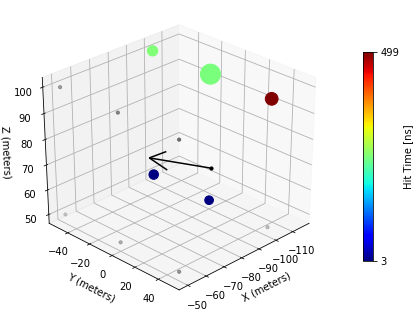

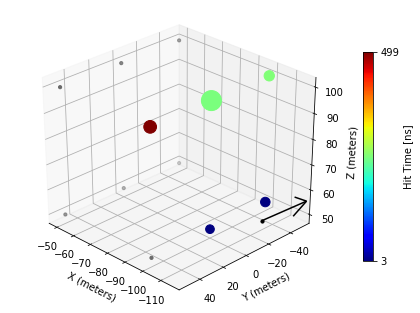

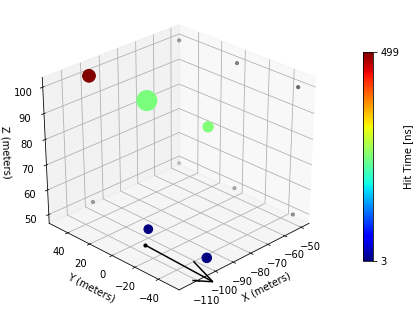

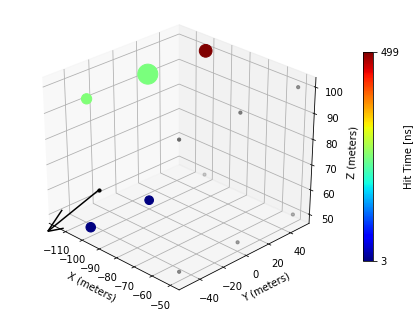

In [42]:
data_dir = "/data/user/abishop/736_project/veff/"
file = "random-1e8-5-run1-neutrino-1.npy"

plot_event(
    load_particle(data_dir+file), 
    detector([],  data_dir+file.split("neutrino")[0]+"detector"+file.split("neutrino")[1]), 
#     title='',                # Title that goes on the plot
#     filename=None,           # Saves plot (if given) to plot_dir with given name
#     step=1,                  # How many steps around the detector (in 360 degrees) you wanna plot
#     show_full_detector=True, # Shows all triggered and not triggered detectors
#     debug=False              # Prints particle info and the triggered DOMs
)